In [16]:
import sys
sys.path.append('../')
from ompl import base as ob
from ompl import geometric as og
from ompl import util as ou

from panav.environment.env import MultiTunnelEnv
from panav.viz import draw_env

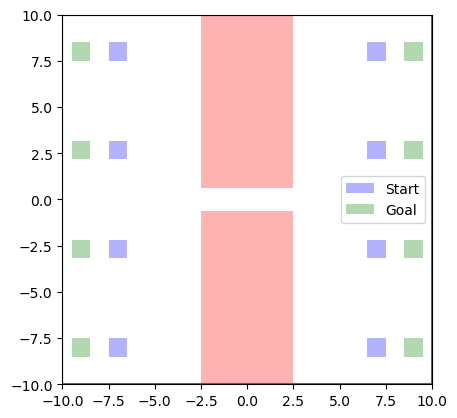

In [153]:
bloating_r = 0.5
vmax = 1.0

N = 8
limits = [(-10,10),(-10,10)] 
n_tunnel = 1

TIMEOUT = 100 # timeout

env = MultiTunnelEnv(n_tunnel = n_tunnel, tunnel_width = bloating_r*2.5,limits=limits, N_agent = N)
draw_env(env)

In [154]:
space_dim = 2
bounds = ob.RealVectorBounds(space_dim)

for axis in range(space_dim):
    bounds.setLow(axis,min(limits[axis]))
    bounds.setHigh(axis,max(limits[axis]))
    
space = ob.RealVectorStateSpace(space_dim)
space.setBounds(bounds)
# spaceTime = ob.SpaceTimeStateSpace(space,vmax)

In [155]:
si = ob.SpaceInformation(space)


In [258]:
import numpy as np
from panav.RRT.utils import has_line_collision
def state_to_py(s,space_dim = 2):
    return np.array([s[i] for i in range(space_dim)])

def path_to_py(path,space_dim = 2):
    # n_states = path.getStateCount()
    out = [state_to_py(v,space_dim) for v in path]
    return np.array(out).T

class Validator(ob.MotionValidator):
    def __init__(self,si,env,bloating_r):
        super().__init__(si)
        self.env = env
        self.bloating_r = bloating_r
    def checkMotion(self,s1,s2):
        x1 = state_to_py(s1)
        x2 = state_to_py(s2)
        return not has_line_collision(self.env,x1,x2,self.bloating_r)

# Set the object used to check which states in the space are valid
validityChecker = Validator(si,env,bloating_r)
si.setMotionValidator(validityChecker)

si.setup()

In [268]:
# Set our robot's starting state to be the bottom-left corner of
# the environment, or (0,0).

def py_to_state(s,space):
    space_dim = len(s)
    x = ob.State(space)
    for i in range(space_dim):
        x[i] = s[i]
    return x



start = py_to_state(env.starts[0],space)
goal = py_to_state(env.goals[0],space)


# Create a problem instance
pdef = ob.ProblemDefinition(si)

# Set the start and goal states
pdef.setStartAndGoalStates(start, goal, bloating_r)

pdef.setOptimizationObjective(ob.PathLengthOptimizationObjective(si))



feasibleSolFound = {'result':False}
def intermediateSol(_,spath,best_cost): # We know the signature of the callback is like this because we looked into the C++ source code of RRT*
    feasibleSolFound['result'] = True
    return spath, best_cost.value()
pdef.setIntermediateSolutionCallback(ob.ReportIntermediateSolutionFn(intermediateSol))

optimizingPlanner = og.RRTstar(si)

# Set the problem instance for our planner to solve
optimizingPlanner.setProblemDefinition(pdef)
optimizingPlanner.setup()

# term_condition = ob.exactSolnPlannerTerminationCondition(pdef)
# attempt to solve the planning problem in the given runtime

exactSolutionReached = lambda : feasibleSolFound['result']

term_condition = ob.PlannerTerminationCondition(ob.PlannerTerminationConditionFn(exactSolutionReached))
solved = optimizingPlanner.solve(term_condition)

Debug:   RRTstar: Planner range detected to be 5.656854
Info:    RRTstar: Started planning with 1 states. Seeking a solution better than 0.00000.
Info:    RRTstar: Initial k-nearest value of 25
Info:    RRTstar: Found an initial solution with a cost of 25.56 in 354 iterations (113 vertices in the graph)
Info:    RRTstar: Created 112 new states. Checked 6328 rewire options. 1 goal states in tree. Final solution cost 25.559


In [269]:
path = path_to_py( pdef.getSolutionPath().getStates())

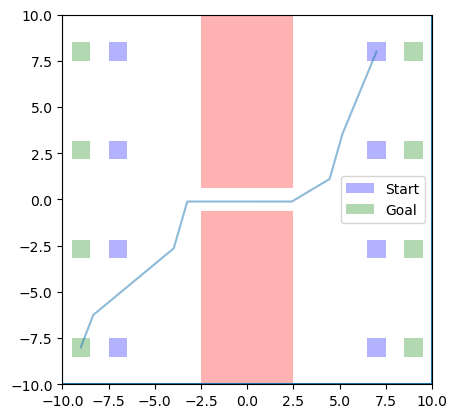

In [270]:
draw_env(env,paths = [path])
